## Dependencies Setup

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

## Hyperparameter Configuration

In [19]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

BATCH_SIZE = 128
EPOCHS = 10
LR = 0.001

Using device: cuda


## Define Transform for the Data

In [12]:
transform = transforms.Compose([
	transforms.Grayscale(),
	transforms.ToTensor(),
	transforms.Normalize((0.5,), (0.5,))
])

## Dataset Setup

In [13]:
dataset = datasets.ImageFolder("../data", transform=transform)
num_classes = len(dataset.classes)
print(f"Number of classes: {num_classes}")

train_size = int(0.7 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
print(f"Total size: {len(dataset)}")
print(f"Train size: {train_size}\t Validation size: {val_size}\t Test size: {test_size}")
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=8, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=8, pin_memory=True)


Number of classes: 10
Total size: 100000
Train size: 70000	 Validation size: 10000	 Test size: 20000


## Model Definition

In [14]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
	def __init__(self, num_classes=10):
		super().__init__()
		self.conv1 = nn.Conv2d(1, 32, 3)
		self.pool = nn.MaxPool2d(2)
		self.conv2 = nn.Conv2d(32, 64, 3)
		self.fc1 = nn.Linear(64 * 5 * 5, 128)
		self.fc2 = nn.Linear(128, num_classes)
		
	def forward(self, x):
		x = self.pool(F.relu(self.conv1(x)))
		x = self.pool(F.relu(self.conv2(x)))
		x = x.view(-1, 64 * 5 * 5)
		x = F.relu(self.fc1(x))
		return self.fc2(x)

## Training

In [15]:
def evaluate_model(model, loader, criterion, device):
    model.eval()
    losses, correct, total = [], 0, 0

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            loss = criterion(outputs, y)
            losses.append(loss.item())
            preds = outputs.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)

    avg_loss = np.mean(losses)
    accuracy = correct / total
    return avg_loss, accuracy

In [20]:
model = SimpleCNN(num_classes=num_classes).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

# Training loop
def train_cnn(num_epochs):
    print("Starting training...")

    train_loss_history, val_loss_history, val_accuracy_history = [], [], []

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_losses = []
        for x, y in train_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            train_losses.append(loss.item())
            loss.backward()
            optimizer.step()

        avg_train_loss = np.mean(train_losses)
        train_loss_history.append(avg_train_loss)
        
        # Validation
        avg_val_loss, accuracy = evaluate_model(model, val_loader, criterion, DEVICE)

        val_loss_history.append(avg_val_loss)
        val_accuracy_history.append(accuracy)

        # Print statistics
        print(f"Epoch {epoch+1}/{num_epochs}\t Train Loss: {avg_train_loss:.4f}\t Validation Loss: {avg_val_loss:.4f}\t Validation Accuracy: {accuracy:.4f}")

    print("Training complete.")
    return train_loss_history, val_loss_history, val_accuracy_history

train_losses, val_losses, val_accuracies = train_cnn(EPOCHS)

Starting training...


Epoch 1/10	 Train Loss: 0.4283	 Validation Loss: 0.3067	 Validation Accuracy: 0.9001
Epoch 2/10	 Train Loss: 0.2494	 Validation Loss: 0.2812	 Validation Accuracy: 0.9142
Epoch 3/10	 Train Loss: 0.2012	 Validation Loss: 0.2613	 Validation Accuracy: 0.9221
Epoch 4/10	 Train Loss: 0.1661	 Validation Loss: 0.2481	 Validation Accuracy: 0.9259
Epoch 5/10	 Train Loss: 0.1374	 Validation Loss: 0.2760	 Validation Accuracy: 0.9232
Epoch 6/10	 Train Loss: 0.1118	 Validation Loss: 0.2722	 Validation Accuracy: 0.9241
Epoch 7/10	 Train Loss: 0.0881	 Validation Loss: 0.3068	 Validation Accuracy: 0.9222
Epoch 8/10	 Train Loss: 0.0730	 Validation Loss: 0.3324	 Validation Accuracy: 0.9230
Epoch 9/10	 Train Loss: 0.0564	 Validation Loss: 0.3656	 Validation Accuracy: 0.9227
Epoch 10/10	 Train Loss: 0.0455	 Validation Loss: 0.4243	 Validation Accuracy: 0.9193
Training complete.


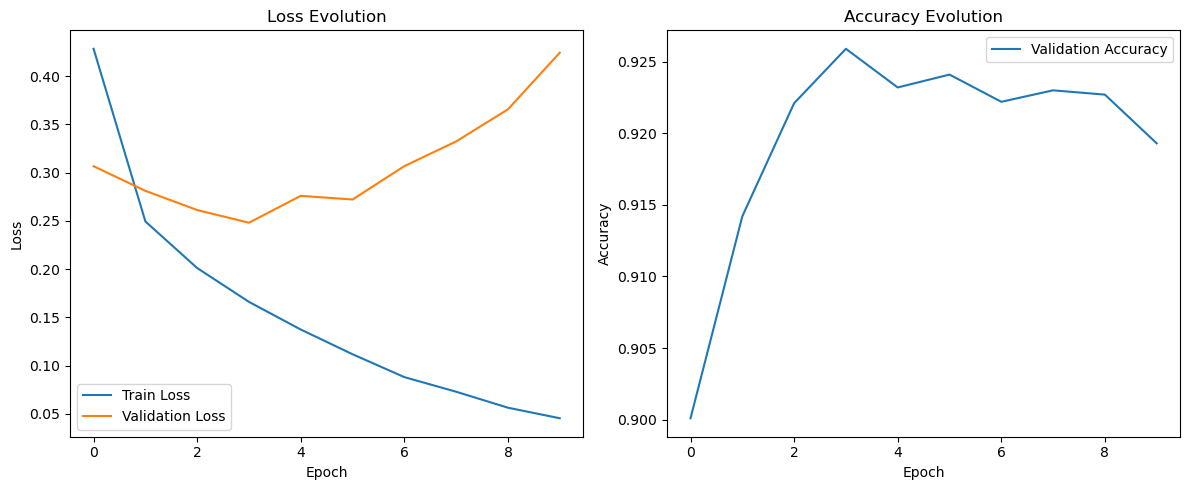

In [21]:
# Plot the results
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Evolution")
plt.legend()

plt.subplot(1,2,2)
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Evolution")
plt.legend()
plt.tight_layout()
plt.show()

## Test

Test Accuracy: 92.39%


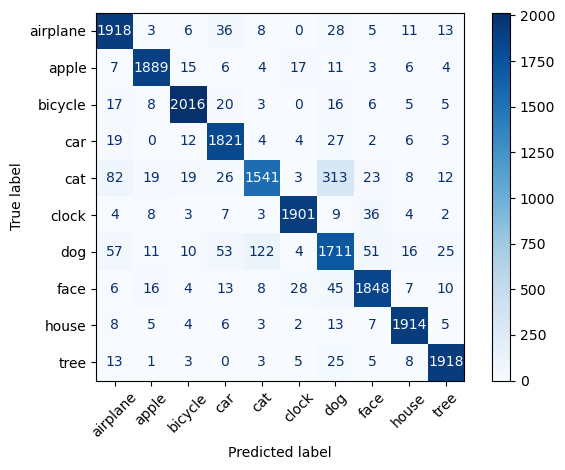

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

CLASSES = dataset.classes

model.eval()

total = 0
correct = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASSES)
disp.plot(xticks_rotation=45, cmap="Blues")
plt.tight_layout()
plt.show()